In [4]:
# Imports
import pandas as pd
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from pandas import Timestamp

from dotenv import load_dotenv
 
load_dotenv(dotenv_path='/Users/daniel/OAN/credentials/contoan/.env')
# Conect to GSHEETS
from oauth2client import file,client, tools
from googleapiclient import discovery
from httplib2 import Http
from matplotlib import font_manager


In [431]:
fM = font_manager.fontManager

In [429]:
for ralway in [x for x in os.listdir('/Users/daniel/Library/Fonts/') if 'Raleway' in x]:
    fM.addfont("/Users/daniel/Library/Fonts/"+ralway)

In [441]:
plt.rcParams['font.family'] = 'Raleway'

In [443]:
plt.rcParams['font.size']=12

In [463]:
plt.rcParams['font.weight']=500

In [2]:
SCOPES = ['https://www.googleapis.com/auth/drive',
          'https://www.googleapis.com/auth/spreadsheets'
        ]
store = file.Storage('/Users/daniel/OAN/credentials/storage.json')
creds = store.get()
if not creds or creds.invalid:
    flow = client.flow_from_clientsecrets('/Users/daniel/OAN/credentials/credentials.json', SCOPES)
    flags= tools.argparser.parse_args(args=[])
    creds = tools.run_flow(flow, store, flags=flags)
    

sheets_service = discovery.build('sheets', 'v4', http=creds.authorize(Http()))
sheet = sheets_service.spreadsheets()

In [3]:
SPREADSHEET_ID = "1KFIB0tDi3uu3niyDjG7KU8uVSLKyhQI6Vy7tuEFXSxw"

In [200]:
##GET DONATIONS DATA
DATA_TO_PULL = "Sheet1" ##SSName
result = sheet.values().get(spreadsheetId=SPREADSHEET_ID,
                            range=DATA_TO_PULL).execute()
data = result.get('values', [])
df = pd.DataFrame(data[1:], columns=data[0])

In [201]:
df.columns

Index(['Codigo', 'Etapa', 'Categoría', 'Tarea', 'Inicio', 'Fin', 'Duración',
       'Precedentes', 'Cadena Critica', 'Eval', 'Completion'],
      dtype='object')

In [202]:
df_copy= df.copy()

In [203]:
#df = df_copy.copy()

In [204]:
df.Inicio = pd.to_datetime(df.Inicio, errors="coerce",  format='%d/%m/%Y')
df.Fin = pd.to_datetime(df.Fin, errors="coerce",  format='%d/%m/%Y')
df.Completion = df.Completion.apply(float)

In [205]:
df.Inicio.min()

Timestamp('2021-11-20 00:00:00')

<ipython-input-506-09262fd98c97>:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('gantt.png', facecolor='#AA3318')
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


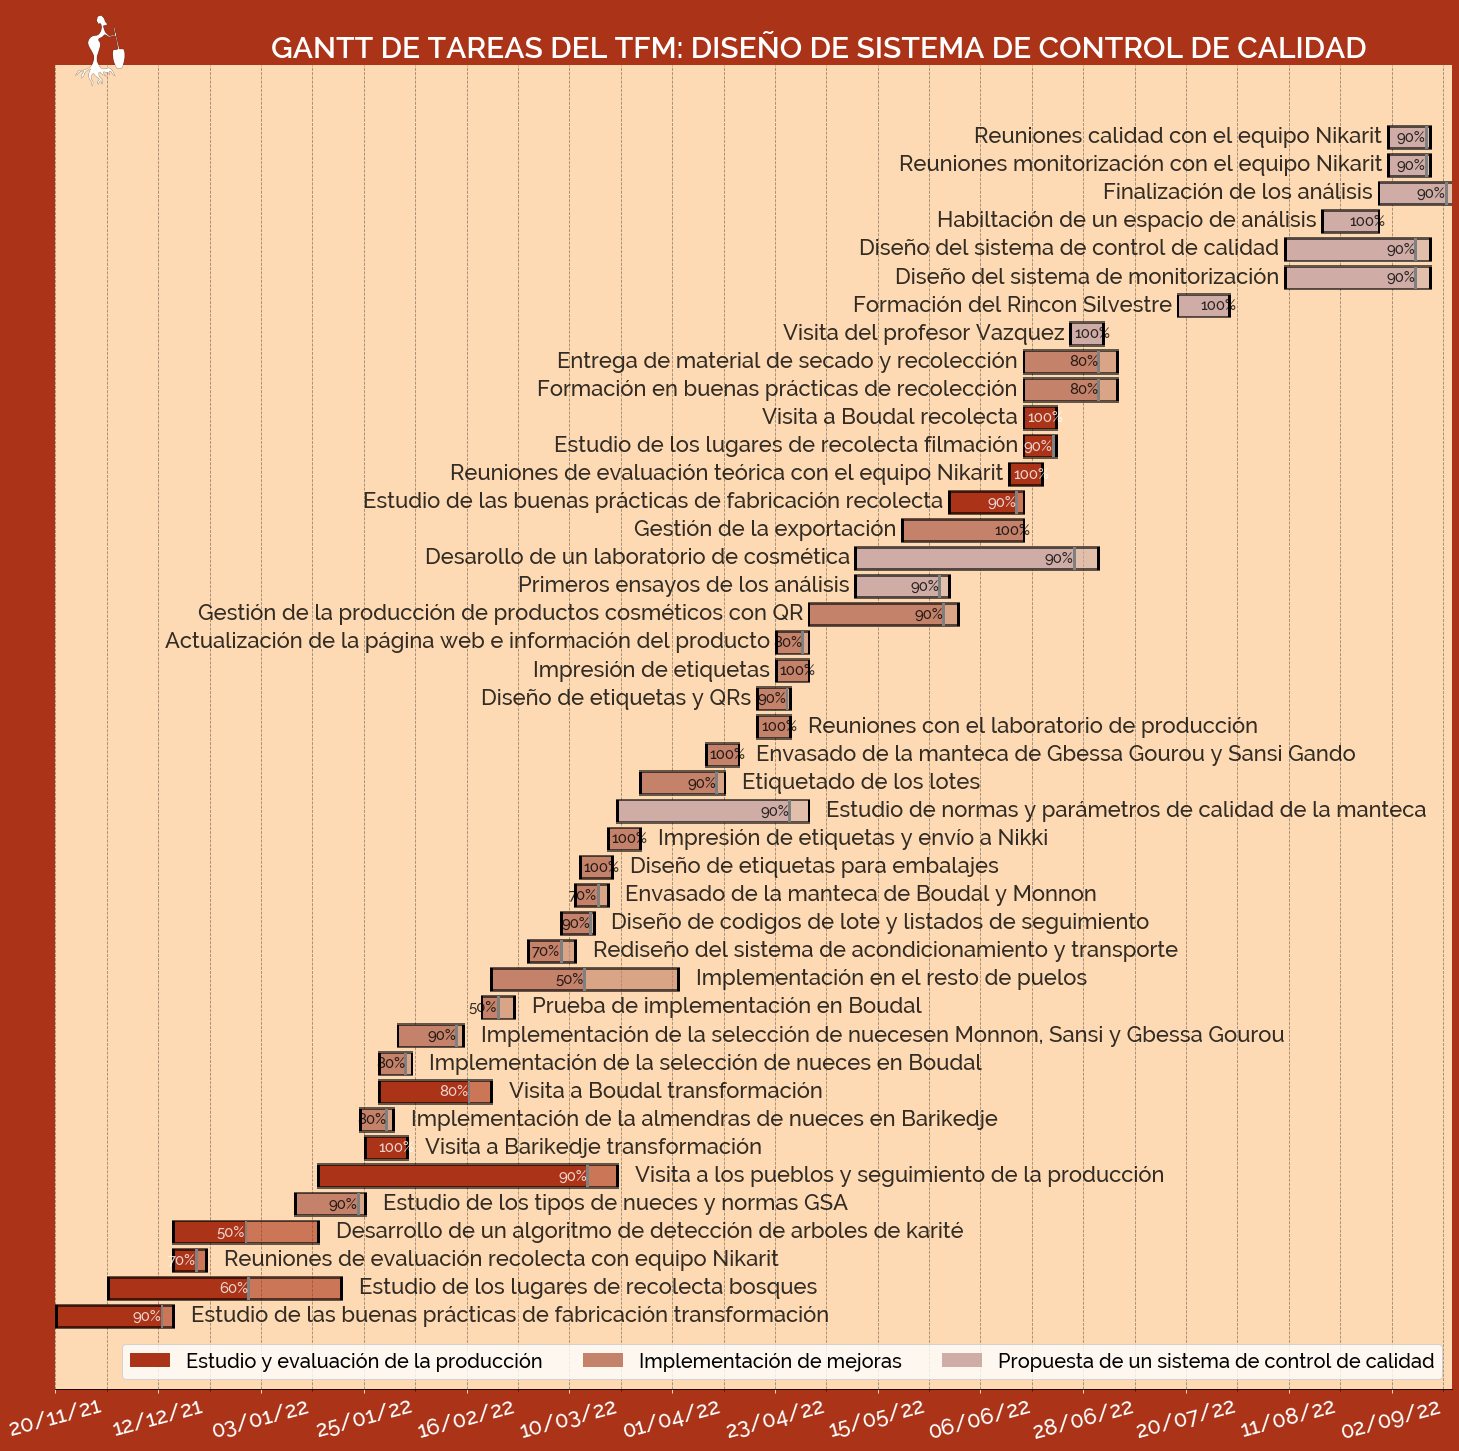

In [506]:
# project start date
proj_start = df.Inicio.min()

# number of days from project start to task start
df['start_num'] = (df.Inicio-proj_start).dt.days

# number of days from project start to end of tasks
df['end_num'] = (df.Fin-proj_start).dt.days


# days between start and end of each task
df['days_start_to_end'] = df.end_num - df.start_num

# days between start and current progression of each task
df['current_num'] = (df.days_start_to_end * df.Completion)

# create a column with the color for each department
def color(row):
    c_dict = {'Estudio y evaluación de la producción':'#AA3318', 'Implementación de mejoras':'#C4826A',
              'Propuesta de un sistema de control de calidad':'#CFADA6'}
    return c_dict[row['Etapa']]

def colorPercentage(row):
    c_dict = {'Estudio y evaluación de la producción':'w', 'Implementación de mejoras':'black',
              'Propuesta de un sistema de control de calidad':'black'}
    return c_dict[row['Etapa']]

df['colorPercentage'] = df.apply(colorPercentage, axis=1)
df['color'] = df.apply(color, axis=1)

bottomPad = 0.04
sizeMiddle = 1-bottomPad-0.04
##### PLOT #####
fig = plt.figure(1, figsize=(20,20), facecolor='#AA3318')
ax = fig.add_axes([0.02, bottomPad, 0.97, sizeMiddle])
ax.set_facecolor('#FDDAB3')


newax = fig.add_axes([0.02,0.94,0.06,0.06])
newax.imshow(im)
newax.axis('off')
# bars

ax.barh(df.Tarea, df.current_num, left=df.start_num, color=df.color)
ax.barh(df.Tarea, df.days_start_to_end, left=df.start_num, color=df.color, alpha=0.6)

ax.barh(np.arange(0, df.Tarea.shape[0], 1)-0.4, 
        df.days_start_to_end+0.6, left=df.start_num,height=0.1, color="black", alpha=0.6)
ax.barh(np.arange(0, df.Tarea.shape[0], 1)+0.4, 
        df.days_start_to_end+0.6, left=df.start_num,height=0.1, color="black", alpha=0.6)

ax.barh(df.Tarea, 0.6, left=df.start_num+df.current_num, color='grey')
ax.barh(df.Tarea, 0.6, left=df.start_num, color='black')
ax.barh(df.Tarea, 0.6, left=df.start_num+df.days_start_to_end, color='black')

textFontSize=22
for idx, row in df.iterrows():
    ax.text(row.start_num+(row.end_num-row.start_num)*row.Completion-6, idx, f"{int(row.Completion*100)}%", va='center',
            alpha=0.8, color=row.colorPercentage,fontsize=15)
    if idx<df.shape[0]/2:
        ax.text(row.end_num+4, idx, row.Tarea, va='center', ha='left', alpha=0.8, color='black',fontsize=textFontSize)
    else:
        ax.text(row.start_num-1, idx, row.Tarea, va='center', ha='right', alpha=0.8, color='black',fontsize=textFontSize)


# grid lines
ax.set_axisbelow(True)
ax.xaxis.grid(color='k', linestyle='dashed', alpha=0.4, which='both')

# ticks
xstep = 22
xticks = np.arange(0, df.end_num.max()+2, xstep)
xticks_labels = pd.date_range(proj_start, end=df.Fin.max()).strftime("%d/%m/%y")
xticks_minor = np.arange(0, df.end_num.max()+1, int(xstep/2))
ax.set_xticks(xticks)
ax.set_xticks(xticks_minor, minor=True)
ax.set_xticklabels(xticks_labels[::xstep], color='w',fontsize=22, rotation=15)
ax.set_yticks([])

plt.setp([ax.get_xticklines()], color='w')

# align x axis
ax.set_xlim(0, df.end_num.max())

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_color('black')



plt.suptitle('GANTT DE TAREAS DEL TFM: DISEÑO DE SISTEMA DE CONTROL DE CALIDAD', x=0.55, color='w',
             fontsize=30,fontweight=600)

##### LEGENDS #####
legend_elements = [Patch(facecolor='#AA3318', label='Estudio y evaluación de la producción'),
                   Patch(facecolor='#C4826A', label='Implementación de mejoras'),
                   Patch(facecolor='#CFADA6', label='Propuesta de un sistema de control de calidad')]


legend = ax.legend(handles=legend_elements, loc='lower right', ncol=3, frameon=True, fontsize=20)
plt.setp(legend.get_texts(), color='black')

plt.savefig('gantt.png', facecolor='#AA3318')

In [215]:
dfComplete = df.groupby(by='Etapa')['Completion'].mean().reset_index()

<ipython-input-495-41ef172e2dd3>:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('viñetas.png', facecolor='#AA3318')
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


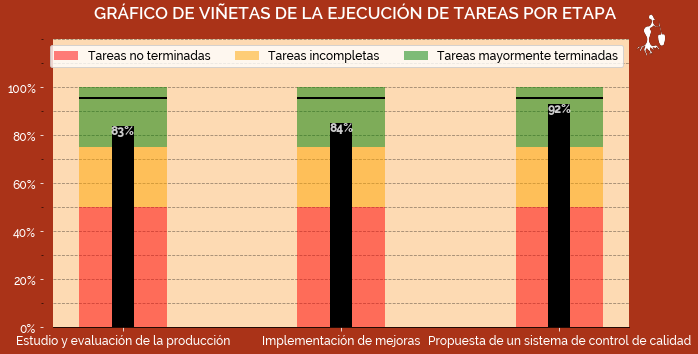

In [495]:
##### PLOT #####
fig = plt.figure(1, figsize=(10,5), facecolor='#AA3318')
ax = fig.add_axes([0.08, 0.1, 0.8, 0.8])
ax.set_facecolor('#FDDAB3')

newax = fig.add_axes([0.84,0.84,0.14,0.14])
newax.imshow(im)
newax.axis('off')
# bars

dfComplete['color'] = dfComplete.apply(color, axis=1)
barwidht=0.4
alphabar=0.5
redEnd = 0.5
orangeEnd=0.75
greenEnd = 1

textFontSize=12
for idx, row in dfComplete.iterrows():
    ax.text(idx, row.Completion-0.02,f"{int(row.Completion*100)}%", va='center', ha='center',
            alpha=0.8, color='white',fontsize=textFontSize,weight='bold')
    
ax.bar(dfComplete.Etapa, redEnd, color='red', alpha=alphabar,width=barwidht)
ax.bar(dfComplete.Etapa, orangeEnd-redEnd, bottom=redEnd, color='orange', alpha=alphabar,width=barwidht)
ax.bar(dfComplete.Etapa, greenEnd-orangeEnd, bottom=orangeEnd, color='green', alpha=alphabar,width=barwidht)

ax.bar(dfComplete.Etapa, dfComplete.Completion, color='black',width=0.1)


ax.bar(dfComplete.Etapa, 0.008, bottom=0.95, color='black', width=barwidht)


ax.tick_params(axis='x', colors='white',labelsize=textFontSize)
ax.tick_params(axis='y', colors='white',labelsize=textFontSize)

ystep = 0.2
ytickEnd = 1.2
yticks = np.arange(0,ytickEnd, ystep)
xticks_labels = [str(int(100*a))+"%" for a in yticks]
yticks_minor = np.arange(0, ytickEnd+0.1, ystep/2)


ax.set_yticks(yticks)
ax.set_yticks(yticks_minor, minor=True)
ax.set_yticklabels(xticks_labels[::xstep], color='w',fontsize=17)

ax.yaxis.set_ticklabels([str(int(100*a))+"%" for a in np.linspace(0,1,6)])

plt.setp([ax.get_xticklines()], color='w')

# grid lines
ax.set_axisbelow(True)
ax.yaxis.grid(color='k', linestyle='dashed', alpha=0.4, which='both')

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_color('black')

##### LEGENDS #####
legend_elements = [Patch(facecolor='red', label='Tareas no terminadas',alpha=alphabar),
                   Patch(facecolor='orange', label='Tareas incompletas',alpha=alphabar),
                   Patch(facecolor='green', label='Tareas mayormente terminadas',alpha=alphabar)]


legend = ax.legend(handles=legend_elements, loc='upper right', ncol=3, frameon=True, fontsize=textFontSize)
plt.setp(legend.get_texts(), color='black')

plt.suptitle('GRÁFICO DE VIÑETAS DE LA EJECUCIÓN DE TAREAS POR ETAPA', x=0.5, y=0.99, color='w',
             fontsize=textFontSize+5,fontweight=600)


plt.savefig('viñetas.png', facecolor='#AA3318')


In [374]:
dfCount = df.groupby(by='Categoría')['Tarea'].count().reset_index()

In [375]:
dfCount = dfCountnotSort.sort_values(by='Tarea').reset_index()

<ipython-input-494-974bd0f85e34>:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('Tareas.png', facecolor='#AA3318')


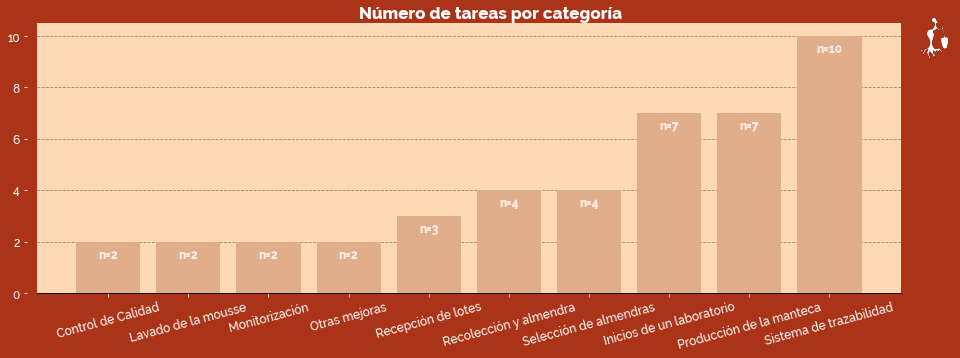

In [494]:
##### PLOT #####
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
im = plt.imread('LogoNikaritBlanco.png')

fig = plt.figure(1, figsize=(15,5), facecolor='#AA3318')
ax = fig.add_axes([0.08, 0.2, 0.8, 0.75])
ax.set_facecolor('#FDDAB3')
# bars

newax = fig.add_axes([0.84,0.84,0.14,0.14])
newax.imshow(im)
newax.axis('off')

ax.bar(dfCount['Categoría'], dfCount['Tarea'],color='#E0AE8A')

textFontSize=12
for idx, row in dfCount.iterrows():
    ax.text(idx, row.Tarea-0.5,f"n={int(row.Tarea)}", va='center', ha='center',
            alpha=0.8, color='white',fontsize=textFontSize,weight='bold')


ax.set_xticklabels(dfCount['Categoría'].to_list(), rotation = 15,color='white')
ax.tick_params(axis='y', colors='white',labelsize=textFontSize)
ax.tick_params(axis='x', colors='white',labelsize=textFontSize)
plt.setp([ax.get_xticklines()], color='w')

# grid lines
ax.set_axisbelow(True)
ax.yaxis.grid(color='k', linestyle='dashed', alpha=0.4, which='both')

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_color('black')


plt.suptitle('Número de tareas por categoría', x=0.5, y=0.996, color='w',
             fontsize=textFontSize+5,weight='bold')


plt.savefig('Tareas.png', facecolor='#AA3318')
